In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys, time, os, datetime
from platform import python_version

print(f"(Sys version) :|: {sys.version} :|:")
os.system("which python")
print(f"(Python version) :#: {python_version()} :#:")

(Sys version) :|: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)] :|:
(Python version) :#: 3.7.12 :#:


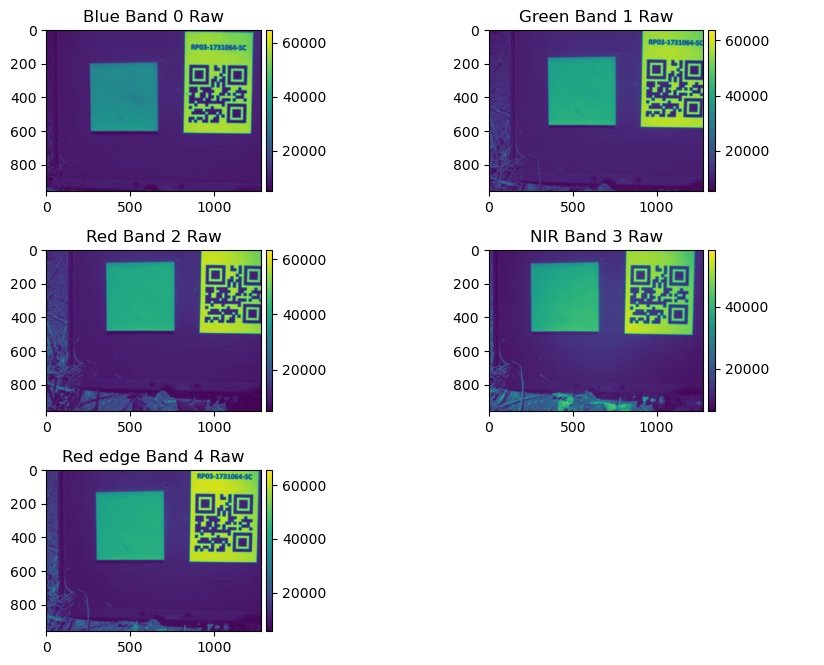

In [6]:
import micasense.metadata as metadata
from PIL import Image as Img
import numpy as np
import micasense.dls as dls
import os, glob
import micasense.capture as capture
import math
import matplotlib.pyplot as plt
from micasense.image import Image
import micasense.imageset as imageset
import micasense.utils as msutils
import micasense.plotutils as plotutils 
import subprocess
import micasense.panel as panel
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import pandas as pd

## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading") 

PlaqueIMG="IMG_0071_"
OutputFolder="OUT2"

# RRDP panelCorners to panel_corners
panel_corners = [[[610, 540], [600, 540], [600, 530], [610, 530]]]

# The location of the files to be recorded will be determined
#Linux filepath
# ReflectanceImagesFolder = os.path.join('.','data','RedEdge3','OUT')
#Windows filepath
# ReflectanceImagesFolder = os.path.join('r:\\','proc_field','RedEdge3', OutputFolder)
ReflectanceImagesFolder = os.path.join('r:\\','proc_field', OutputFolder)

# Path part of raw images will be written in this part
#Linux filepath
#images_path = os.path.join('.','data','RedEdge3') 
#Windows filepath
images_path = os.path.join('r:\\','proc_field','RedEdge3')
# images_path_B = os.path.join('r:\\','proc_field','RedEdge3')

#Linux filepath
# image_names = os.path.join('.','data','RedEdge3','OUT')
#Windows filepath
# image_names = glob.glob(os.path.join(images_path, 'IMG_0063_*.tif'))
image_names = glob.glob(os.path.join(images_path,PlaqueIMG+'*.tif'))

# panelNames
#Linux filepath
# image_names = os.path.join('.','data','RedEdge3','OUT')
#Windows filepath
# img = Image(os.path.join('r:\\','proc_field','RedEdge3','IMG_0063_1.tif'))
img = Image(os.path.join('r:\\','proc_field','RedEdge3',PlaqueIMG+'1.tif'))

#Linux filepath
# image_names = os.path.join('.','data','RedEdge3','OUT')
#Windows filepath
# imgPNB = glob.glob(os.path.join(imgNB,'IMG_0063_4.tif'))[0]
imgPNB = glob.glob(os.path.join(images_path,PlaqueIMG+'4.tif'))[0]

cap = capture.Capture.from_filelist(image_names)
cap.plot_raw(fig_size=(9,6.75),num=1)

In [7]:
print('images_path or imgNB: {0}'.format(images_path))
print(ReflectanceImagesFolder)
print(images_path)
print(image_names)

images_path or imgNB: r:\proc_field\RedEdge3
r:\proc_field\OUT2
r:\proc_field\RedEdge3
['r:\\proc_field\\RedEdge3\\IMG_0071_5.tif', 'r:\\proc_field\\RedEdge3\\IMG_0071_1.tif', 'r:\\proc_field\\RedEdge3\\IMG_0071_2.tif', 'r:\\proc_field\\RedEdge3\\IMG_0071_3.tif', 'r:\\proc_field\\RedEdge3\\IMG_0071_4.tif']


In [8]:
print(cap)
print('CAP: {0}'.format(cap))

CAP: <micasense.capture.Capture object at 0x0000027C66FF7BC8>


In [9]:
print(panel_corners)
print()
print(panel_corners[0])
print()
pnl = panel.Panel(img,panelCorners = panel_corners[0])
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

[[[610, 540], [600, 540], [600, 530], [610, 530]]]

[[610, 540], [600, 540], [600, 530], [610, 530]]

Panel found: True
Panel serial: RP03-1731064-SC
QR Code Corners:
[[ 847  547]
 [1186  552]
 [1193  214]
 [ 852  211]]
Panel mean raw pixel value: 35145.115702479336
Panel raw pixel standard deviation: 605.1840399003648
Panel region pixel count: 121
Panel region saturated pixel count: 121


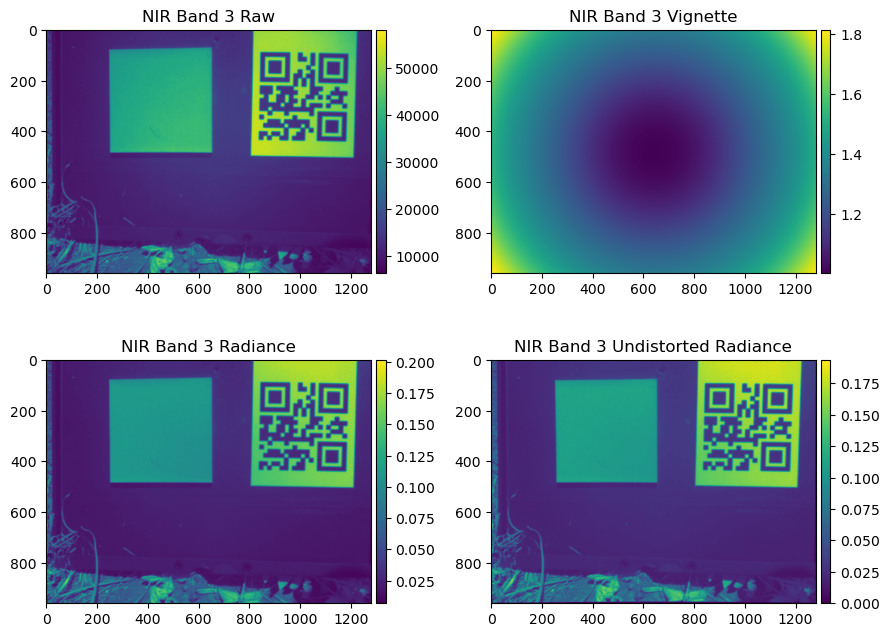

In [10]:
imgB = Image(imgPNB)
imgB.plot_all(figsize=(9,6.75),num=2)

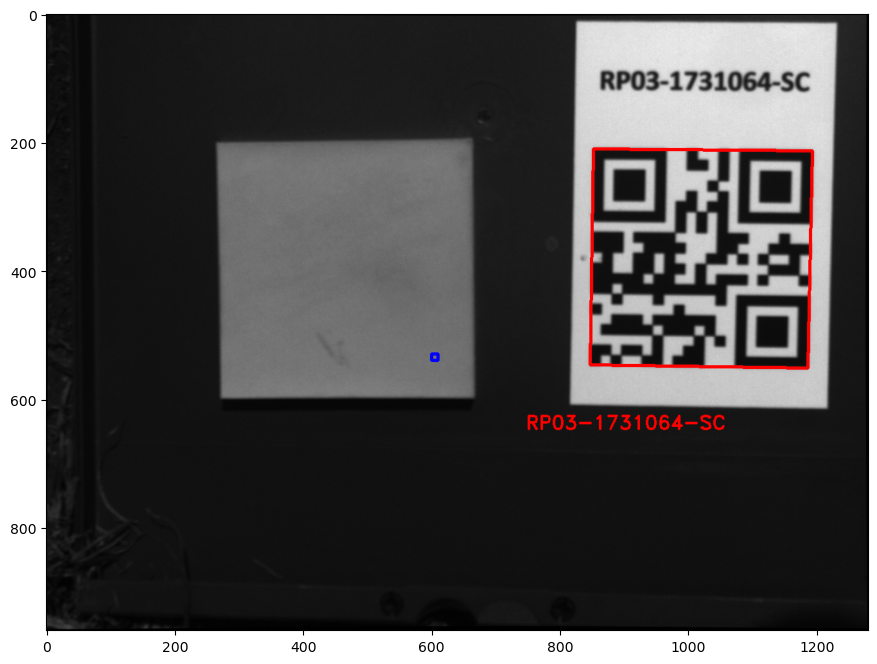

(<Figure size 900x675 with 1 Axes>, <AxesSubplot:>)

In [11]:
pnl.plot(figsize=(9,6.75),num=3)

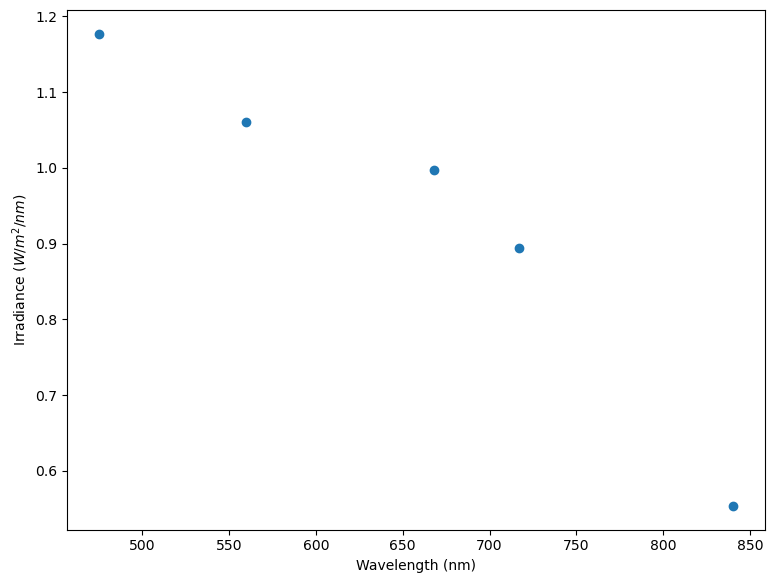

In [12]:
# RRDP
# cap.set_panelCorners(panelCorners)
cap.set_panel_corners(panel_corners)

# DLS2 - ground seviyesinde
dls_irradiances = []
center_wavelengths = []
for img in cap.images:
    dls_irr = img.horizontal_irradiance
    dls_irradiances.append(dls_irr)
    center_wavelengths.append(img.center_wavelength)

plt.figure(figsize=(9,6.75),num=4)
plt.scatter(center_wavelengths, dls_irradiances)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance ($W/m^2/nm$)')
plt.show()
plt.close()

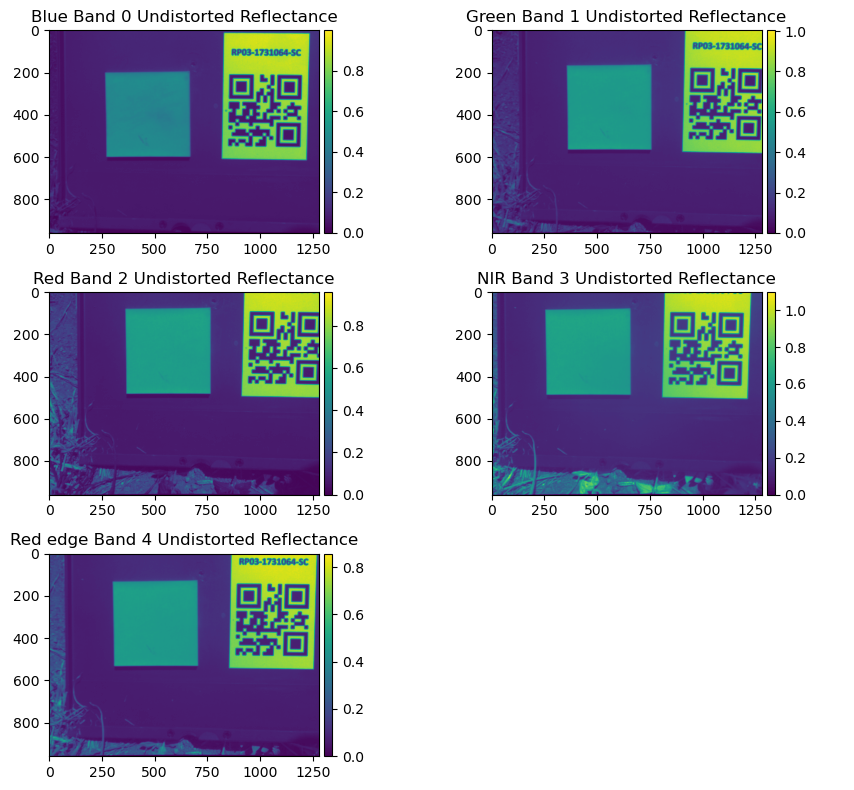

In [13]:
#cap.plot_undistorted_reflectance(dls_irradiances)
cap.plot_undistorted_reflectance(dls_irradiances,fig_size=(9,8),num=5)

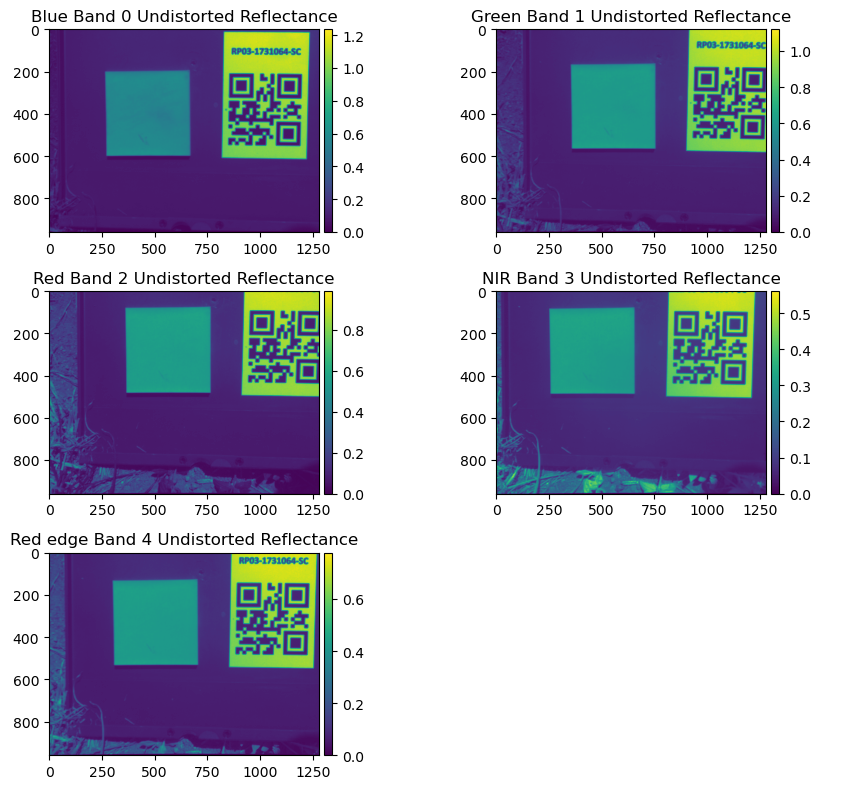

In [14]:
# panel_reflectance_by_band = [0.519, 0.521, 0.52, 0.518, 0.519]  # Altum band_index
panel_reflectance_by_band = [0.57, 0.57, 0.56, 0.50, 0.55]  # RedEdge3 band_index

panel_radiances = np.array(cap.panel_radiance())
irr_from_panel = math.pi * panel_radiances / panel_reflectance_by_band
dls_correction = irr_from_panel / dls_irradiances
cap.plot_undistorted_reflectance(dls_irradiances * dls_correction,fig_size=(9,8),num=6)

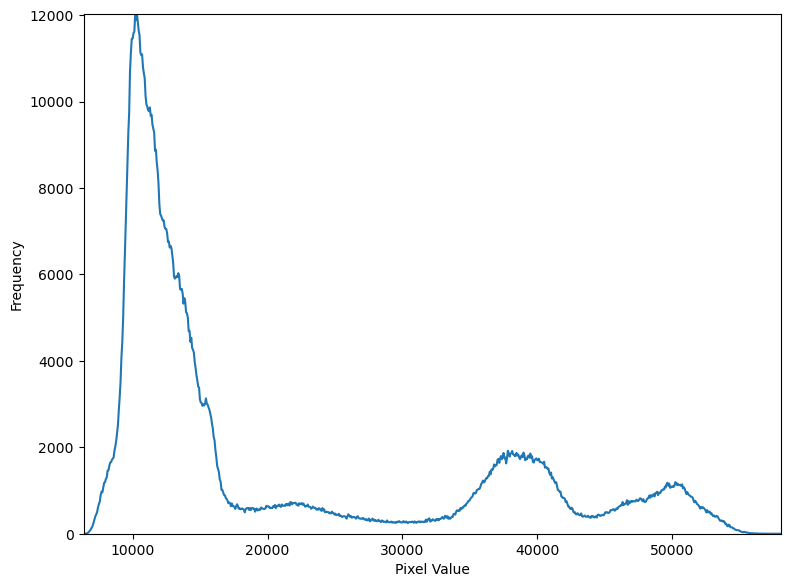

In [15]:
import cv2

nbins = 1024
vmin = 0
vmax = 2**16
bins = range(vmin,vmax, int(vmax/nbins))
hist = cv2.calcHist([imgB.raw().ravel()],[0],None,[nbins],[vmin,vmax])
plt.figure(figsize=(9,6.75),num=7)
plt.plot(bins,hist)
plt.xlim(imgB.raw().min(),imgB.raw().max())
plt.ylim(0,hist.max())
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()
plt.close()

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

c:\imageprocessing\micasense\imageset.py:139: PendingDeprecationWarning: The progress_callback parameter will be deprecated in favor of use_tqdm
  category=PendingDeprecationWarning)


Loading ImageSet from: r:\proc_field\RedEdge3
Columns: ['timestamp', 'latitude', 'longitude', 'altitude', 'capture_id', 'dls-yaw', 'dls-pitch', 'dls-roll', 'irr-475', 'irr-560', 'irr-668', 'irr-840', 'irr-717']


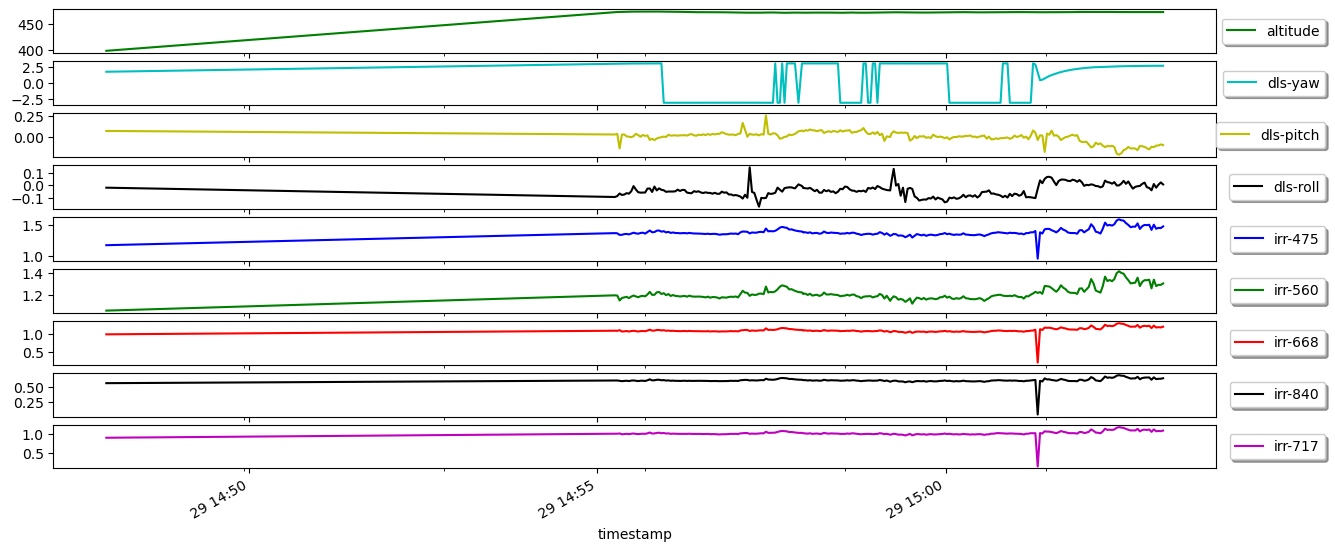

In [16]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import pandas as pd

## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

imgset = imageset.ImageSet.from_directory(images_path, progress_callback=update_f)

data, columns = imgset.as_nested_lists()
print("Columns: {}".format(columns))
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

# 'b' as blue |'g' as green | 'r' as red | 'c' as cyan | 'm' as magenta | 'y' as yellow | 'k' as black | 'w' as white
ax=df.plot(y=columns[3:], subplots=True, figsize=(15,6.75), style=['g','c','y','k','b','g','r','k','m'])
for a in ax:
    a.legend(loc='right', bbox_to_anchor=(1.1, 0.5), ncol=1, fancybox=True, shadow=True)
plt.show()
plt.close()

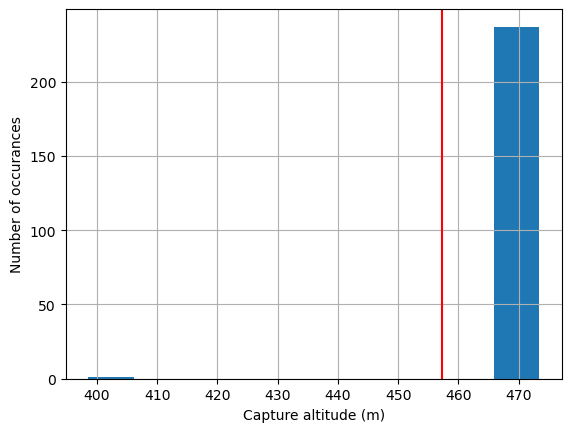

In [18]:
plt.figure(num=8)
# plot the histogram of the altitude data
df.altitude.hist()
# find the altitude above which the flight images occur
cutoff_altitude = df.altitude.mean()-3.0*df.altitude.std()
plt.axvline(x=cutoff_altitude,c='r')
plt.xlabel('Capture altitude (m)')
plt.ylabel('Number of occurances')
plt.show()
plt.close()

In [17]:
channels = ['*.tif']

def band_adi(image):
    meta = metadata.Metadata(image)
    band = meta.get_item('XMP:BandName')
    return band

dls_correction_blue = dls_correction[0]
dls_correction_green = dls_correction[1]
dls_correction_red = dls_correction[2]
dls_correction_nir = dls_correction[3]
dls_correction_redEdge = dls_correction[4]

center_wavelengths=[]

for channel in channels:
    files= glob.glob(os.path.join(images_path,'*'+ channel + '*'))
    for file in files:
        img = Image(file)
        band = band_adi(file)
        cap = capture.Capture.from_file(file)
        dls_irr = img.horizontal_irradiance
        meta = metadata.Metadata(file)
        center_wavelengths.append(img.center_wavelength)

        if file.endswith(".tif"):
            figname = file[:-4] + '_reflectance.tif'
            print("figname", figname)

        path, filename = os.path.split(file)
         
        if band == "Blue":
            Reflectance = img.undistorted_reflectance(dls_irr* dls_correction_blue)
            #plotutils.plotwithcolorbar(Reflectance, 'Reflektans görüntüsü')
            print("Band ok1-Blue")

        if band == "Green":
            Reflectance = img.undistorted_reflectance(dls_irr* dls_correction_green)
            #plotutils.plotwithcolorbar(Reflectance, 'Reflektans görüntüsü')
            print("Band ok2-Green")

        if band == "Red":
            Reflectance = img.undistorted_reflectance(dls_irr* dls_correction_red)
            #plotutils.plotwithcolorbar(Reflectance, 'Reflektans görüntüsü')
            print("Band ok3-Red")

        if band == "NIR":
            Reflectance = img.undistorted_reflectance(dls_irr* dls_correction_nir)
            #plotutils.plotwithcolorbar(Reflectance, 'Reflektans görüntüsü')
            print("Band ok4-NIR")

        if band == "Red edge":
            Reflectance = img.undistorted_reflectance(dls_irr* dls_correction_redEdge)
            #plotutils.plotwithcolorbar(Reflectance, 'Reflektans görüntüsü')
            print("Band ok5-RedEdge")

        outfile = os.path.join(ReflectanceImagesFolder,filename)
        print(outfile)
        im = Img.fromarray(Reflectance)
        with open(outfile, 'w') as img: #create CSV
            im.save(os.path.join(outfile),format= 'tiff')##123
            print("Save image")

    if os.environ.get('exiftoolpath') is not None:
        exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))
    else:
        exiftool_cmd = 'exiftool'
        
    cmd = 'exiftool -tagsFromFile "{}" -ALL -XMP {}'.format(file, figname)
    print(cmd)
#RRDP
#subprocess.check_call(cmd)
    # if(subprocess.check_call(cmd) == 0):
    #     print("Successfully updated stack metadata")

    #     subprocess.run(['exiftool', '-tagsFromFile', file, '-ALL', '-XMP', figname])
    #     print("Exiftool 1")

    #     subprocess.run(['exiftool', '-delete_original!', figname])
    #     print("Exiftool OK")

figname r:\proc_field\RedEdge3\IMG_0340_5_reflectance.tif
Band ok5-RedEdge
r:\proc_field\OUT2\IMG_0340_5.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0341_1_reflectance.tif
Band ok1-Blue
r:\proc_field\OUT2\IMG_0341_1.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0341_2_reflectance.tif
Band ok2-Green
r:\proc_field\OUT2\IMG_0341_2.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0341_3_reflectance.tif
Band ok3-Red
r:\proc_field\OUT2\IMG_0341_3.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0341_4_reflectance.tif
Band ok4-NIR
r:\proc_field\OUT2\IMG_0341_4.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0341_5_reflectance.tif
Band ok5-RedEdge
r:\proc_field\OUT2\IMG_0341_5.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0342_1_reflectance.tif
Band ok1-Blue
r:\proc_field\OUT2\IMG_0342_1.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0342_2_reflectance.tif
Band ok2-Green
r:\proc_field\OUT2\IMG_0342_2.tif
Save image
figname r:\proc_field\RedEdge3\IMG_0342_3_reflectance.tif


CalledProcessError: Command 'exiftool -tagsFromFile "r:\proc_field\RedEdge3\IMG_0340_4.tif" -ALL -XMP r:\proc_field\RedEdge3\IMG_0340_4_reflectance.tif' returned non-zero exit status 1.